# Assignment 1
Linear and circular convolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.linalg import toeplitz, circulant, dft

from skimage.metrics import structural_similarity as ssim


plt.rcParams.update({
    "font.serif":["cm"],
    "font.size": 12})

colors = {
    "blue": "#377eb8",
    "orange": "#ff7f00",
    "green": "#4daf4a",
    "pink": "#f781bf",
    "brown": "#a65628",
    "purple": "#984ea3",
    "gray": "#999999",
    "red": "#e41a1c",
    "yellow": "#dede00",
    "black": "#000000",
}

## Part 1: Starter Exercise

Before using built-in functions, write the convolution function once!

**The Goal:** Implement 1D Linear Convolution (`mode='full'`) in three ways and verify they are identical.
1. **Manual Loops:** To appreciate the computational complexity.
2. **Matrix Algebra:** To leverage linear algebra tools.
3. **Built-in:** To make things more efficient.

In [4]:
def manual_convolution_loops(x, h, mode='full'):
    """
    Computes convolution y[n] = sum(x[k] * h[n-k]) using nested loops.
    Supports 'full', 'same', and 'valid' modes.
    TODO: Implement the convolution logic here
    """    
    y = np.zeros(len(x) + len(h) - 1)
    m = len(h)
    x_padded = np.pad(x, (m-1, m-1), mode='constant', constant_values=0)
    
    for n in range(len(y)):
        y[n] = np.sum(x_padded[n:n+m]*h[::-1])

    if mode == 'full':
        return y
    elif mode == 'same':
        pad = (len(h) - 1) // 2
        return y[pad:-pad]
    elif mode == 'valid':
        pad = len(h) - 1
        return y[pad:-pad]
    
def test_implementations():
    x = np.array([1, 2, 3, 4, 5])
    h = np.array([1, -1, 2])
    
    print(f"Input x: {x}")
    print(f"Filter h: {h}")
    print(f"-"*30)

    for mode in ['full', 'same', 'valid']:
        # 1. Manual Implementation
        y_manual = manual_convolution_loops(x, h, mode=mode)
        
        # 2. Built-in Implementation (Numpy)
        y_builtin = np.convolve(x, h, mode=mode)
        
        print(f"Mode '{mode}':\n")
        print(f"  Manual:   {y_manual}")
        print(f"  Built-in: {y_builtin}")
        
        if np.allclose(y_manual, y_builtin):
            print(f"  Result:   MATCH")
        else:
            print(f"  Result:   MISMATCH")
    print(f"-"*30)

test_implementations()

Input x: [1 2 3 4 5]
Filter h: [ 1 -1  2]
------------------------------
Mode 'full':

  Manual:   [ 1.  1.  3.  5.  7.  3. 10.]
  Built-in: [ 1  1  3  5  7  3 10]
  Result:   MATCH
Mode 'same':

  Manual:   [1. 3. 5. 7. 3.]
  Built-in: [1 3 5 7 3]
  Result:   MATCH
Mode 'valid':

  Manual:   [3. 5. 7.]
  Built-in: [3 5 7]
  Result:   MATCH
------------------------------


## Part 2: Linear Convolution as a Toeplitz Matrix

Now that we understand the loops, we show that convolution is simply a matrix-vector product $y = Ax$.

In [5]:
def demo_toeplitz_convolution():
    # Define a simple signal x and filter h
    x = np.array([1, 2, 3, 4])
    h = np.array([1, -1, 2]) # Length 3
    
    # Standard Numpy Convolve
    y_numpy = np.convolve(x, h, mode='full')
    print(f"Standard Convolution Output: {y_numpy}")
    
    # TODO: Construct Toeplitz matrix
    H_mat = toeplitz(
        np.concatenate([h, np.zeros(len(x)-1)]),
        np.concatenate([h[0:1], np.zeros(len(x)-1)])
    )
    
    print("\nToeplitz Convolution Matrix (H):")
    print(H_mat)
    #  
    # TODO: Perform matrix multiplication
    y_matrix = H_mat@x
    print(f"\nMatrix Multiplication Output: {y_matrix}")
    
    assert np.allclose(y_numpy, y_matrix), "Mismatch between numpy and matrix method!"

demo_toeplitz_convolution()

def demo_circulant_matrix():
    x = np.array([1, 2, 3, 4])
    h = np.array([1, 0, -1, 0]) # Same length as x for circular conv
    
    # TODO: Create circulant matrix from h
    C = circulant(h)
    print("Circulant Matrix C:")
    print(C)
    
    # TODO: Compare matrix multiplication with FFT-based circular convolution
    y_matrix = C @ x
    y_fft = np.fft.ifft(np.fft.fft(x) * np.fft.fft(h)).real
    print(f"\nMatrix Result: {y_matrix}")
    print(f"FFT Result: {y_fft}")
    
demo_circulant_matrix()

Standard Convolution Output: [1 1 3 5 2 8]

Toeplitz Convolution Matrix (H):
[[ 1.  0.  0.  0.]
 [-1.  1.  0.  0.]
 [ 2. -1.  1.  0.]
 [ 0.  2. -1.  1.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  2.]]

Matrix Multiplication Output: [1. 1. 3. 5. 2. 8.]
Circulant Matrix C:
[[ 1  0 -1  0]
 [ 0  1  0 -1]
 [-1  0  1  0]
 [ 0 -1  0  1]]

Matrix Result: [-2 -2  2  2]
FFT Result: [-2. -2.  2.  2.]


## Part 3: Audio De-reverberation (1D Application)

Use the functions to construct reverberated audio and perform de-reverberation
* **Model:** Room impulse response
* **Input:** Standard speech file
* **Restoration:** Inverse/Wiener filter

In [6]:
import scipy.io.wavfile as wavfile
import urllib.request
import io

In [21]:
def get_audio_sample():
    """Downloads a standard wav file or generates a fallback."""
    url = "https://www.signalogic.com/melp/EngSamples/Orig/male.wav"
    try:
        print(f"Attempting to download audio from {url}...")
        response = urllib.request.urlopen(url)
        data = response.read()
        sr, y = wavfile.read(io.BytesIO(data))
        # Normalize to -1..1
        y = y.astype(float) / np.max(np.abs(y))
        # Take a 3-second slice to keep processing fast
        y = y[:sr*3]
        print("Download successful.")
        return sr, y
    except Exception as e:
        print(f"Download failed: {e}. Generating fallback audio.")

In [22]:
def create_room_impulse_response(sr):
    """Creates a synthetic Room Impulse Response (Echo)."""
    # A decaying exponential with random spikes
    T_echo = 0.3 # 300ms reverb
    n_echo = int(sr * T_echo)
    t = np.linspace(0, T_echo, n_echo)
    
    # Exponential decay envelope
    envelope = np.exp(-10 * t)
    
    # Random reflections
    noise = np.random.randn(n_echo)
    rir = noise * envelope
    
    # Normalize energy
    rir = rir / np.sqrt(np.sum(rir**2))
    return rir

In [23]:
def wiener_deconvolution(observed, kernel, K):
    """
    Apply Wiener Deconvolution in Frequency Domain.
    TODO: Implement H_hat = H* / (|H|^2 + K)
    """
    H = np.fft.fft(kernel, n=len(observed))
    Y = np.fft.fft(observed)
    
    H_conj = np.conj(H)
    H_mag_sq = np.abs(H)**2
    H_hat = H_conj / (H_mag_sq + K)
    
    X_hat = H_hat * Y
    x_hat = np.fft.ifft(X_hat).real
    return x_hat

In [30]:
# 1. Setup
sr, clean_speech = get_audio_sample()
rir = create_room_impulse_response(sr)

# 2. Simulate "The Room" (Convolution)
reverbed_speech = np.convolve(clean_speech, rir, mode='same')

# 3. Add Noise (The "Hiss")
noise_level = 0.02
noise = np.random.randn(len(reverbed_speech)) * noise_level
observed_signal = reverbed_speech + noise

# 4. Attempt Recovery
recovered_naive = wiener_deconvolution(observed_signal, rir, K=0)
recovered_wiener = wiener_deconvolution(observed_signal, rir, K=noise_level**2/np.var(observed_signal))

Attempting to download audio from https://www.signalogic.com/melp/EngSamples/Orig/male.wav...
Download successful.


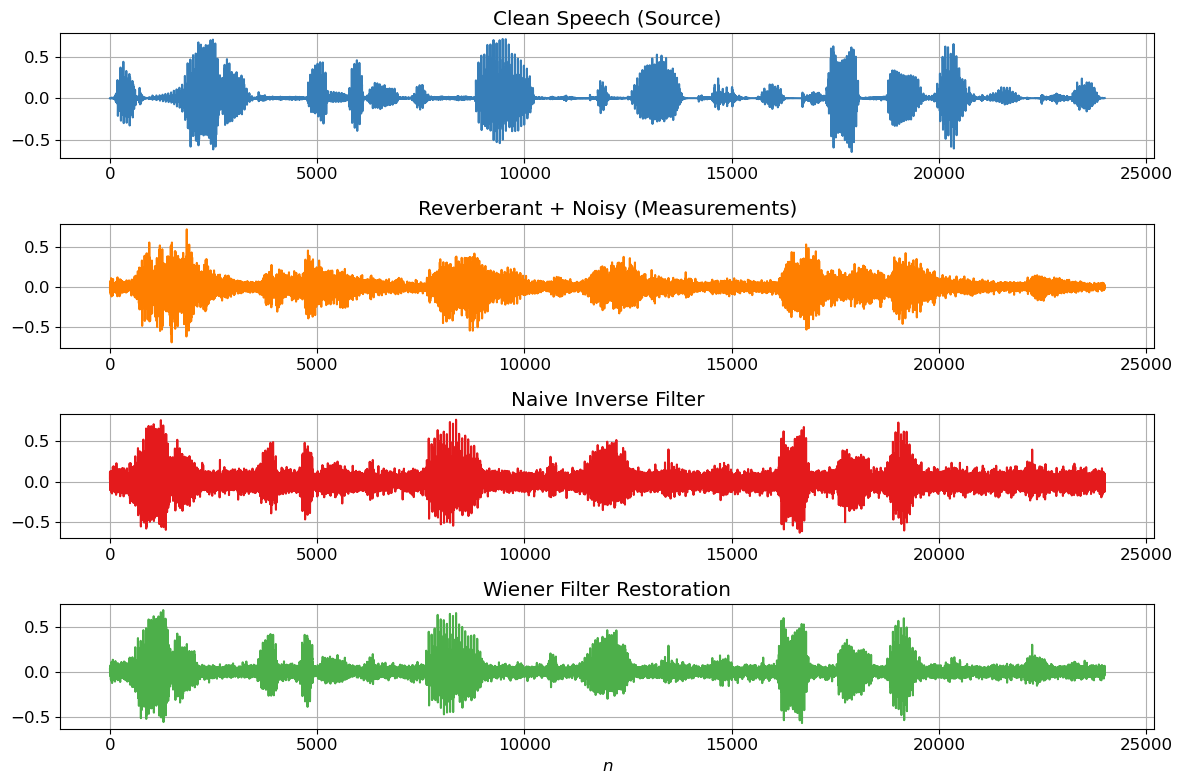

In [31]:
# 5. Visualization
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.title("Clean Speech (Source)")
plt.plot(clean_speech, color=colors['blue'])
plt.grid(True)

plt.subplot(4, 1, 2)
plt.title("Reverberant + Noisy (Measurements)")
plt.plot(observed_signal, color=colors['orange'])
plt.grid(True)

plt.subplot(4, 1, 3)
plt.title("Naive Inverse Filter")
plt.plot(recovered_naive, color=colors['red'])
plt.grid(True)

plt.subplot(4, 1, 4)
plt.title("Wiener Filter Restoration")
plt.plot(recovered_wiener, color=colors['green'])
plt.grid(True)
plt.xlabel("$n$")

plt.tight_layout()
plt.show()

In [26]:
import IPython.display as ipd

print("1. Clean Speech")
ipd.display(ipd.Audio(clean_speech, rate=sr))

print("2. Reverberant + Noisy")
ipd.display(ipd.Audio(observed_signal, rate=sr))

print("3. Naive Inverse Filter")
ipd.display(ipd.Audio(recovered_naive, rate=sr))

print("4. Wiener Restored")
ipd.display(ipd.Audio(recovered_wiener, rate=sr))

1. Clean Speech


2. Reverberant + Noisy


3. Naive Inverse Filter


4. Wiener Restored


## Part 4/5: 2D Image Deblurring (Set5 & Levin Kernels)

We apply the same Wiener Filter logic to images.
* **Gaussian Blur:** Simulates out-of-focus lens.
* **Motion Blur:** Simulates camera shake (Levin-like kernels).
* **Inverse Filter:** Fails due to zeros in the blur kernel.
* **Wiener Filter:** Restores structure by regularizing the inversion.

In [7]:
from PIL import Image
def get_image_sample():
    """Downloads 'baby.png' from Set5."""
    url = "https://raw.githubusercontent.com/jbhuang0604/SelfExSR/master/data/Set5/image_SRF_4/img_001_SRF_4_HR.png"
    try:
        print(f"Downloading Set5 image from {url}...")
        with urllib.request.urlopen(url) as response:
            data = response.read()
        img = Image.open(io.BytesIO(data)).convert('L') # Convert to Grayscale
        img = np.array(img).astype(float) / 255.0
        print("Download successful.")
        return img
    except Exception as e:
        print(f"Download failed ({e}). Generating synthetic text image...")

In [8]:
def get_gaussian_kernel(size=15, sigma=3):
    """Generates a 2D Gaussian Kernel."""
    x, y = np.meshgrid(np.arange(-(size//2),size//2+1),np.arange(-(size//2),size//2+1))
    G_xy = np.exp(-(x**2+y**2)/(2*sigma**2))
    G_xy /= np.sum(G_xy)
    return G_xy

def get_motion_kernel(size=15, angle=45):
    """Generates a Motion Blur Kernel (Line)."""
    kernel = np.zeros((size, size))
    # Draw a line in the center using a simple algorithm
    center = size // 2
    slope = np.tan(np.deg2rad(angle))
    for x in range(size):
        offset = int((x - center) * slope)
        y = center - offset
        if 0 <= y < size:
            kernel[y, x] = 1.0
    return kernel / np.sum(kernel)

In [9]:
def wiener_deconvolution_2d(img_blurred, kernel, K):
    """
    Performs 2D Wiener Deconvolution in Frequency Domain.
    """
    H = np.fft.fft2(kernel, s=img_blurred.shape)
    Y = np.fft.fft2(img_blurred)
    
    H_conj = np.conj(H)
    H_mag_sq = np.abs(H)**2
    H_hat = H_conj / (H_mag_sq + K)
    
    X_hat = H_hat * Y
    x_hat = np.fft.ifft2(X_hat).real
    return x_hat

In [43]:
# 1. Setup Data
img = get_image_sample()
k_motion = get_motion_kernel(size=15, angle=30)

# 2. Simulate Degradation
# We use fftconvolve for accurate boundary handling (or standard convolve2d)
img_blurred = scipy.signal.convolve2d(img, k_motion, mode='same', boundary='wrap')

# 3. Add Noise
noise_sigma = 0.01  # Gaussian noise
noise = np.random.randn(*img.shape) * noise_sigma
img_degraded = img_blurred + noise

# 4. Restoration
# K should be approx (Noise Power / Signal Power) or tuned manually
# Try K=0 for Inverse Filter (will explode)
img_inverse = wiener_deconvolution_2d(img_degraded, k_motion, K=0) 
# Try Tuned K for Wiener
K = 1e-1
img_wiener = wiener_deconvolution_2d(img_degraded, k_motion, K=K)

Download successful.


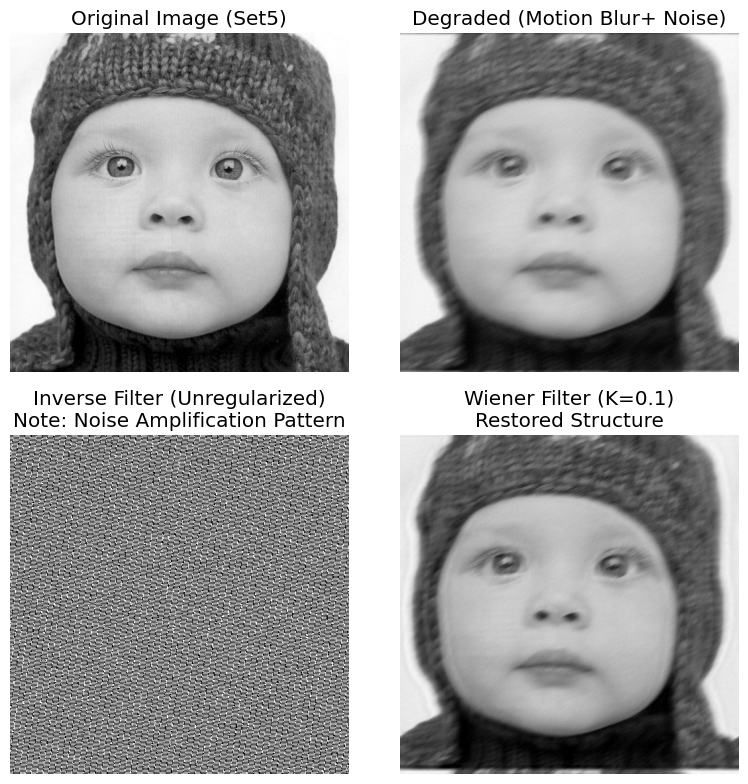

SSIM Scores:
  Degraded Image SSIM: 0.6747
  Inverse Filter SSIM: 0.0032
  Wiener Filter SSIM: 0.4662
PSNR Scores:
  Degraded Image PSNR: 25.0672
  Inverse Filter PSNR: -27.7602
  Wiener Filter PSNR: 16.7560


In [44]:
# 5. Visualization
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image (Set5)")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title(f"Degraded (Motion Blur+ Noise)")
plt.imshow(img_degraded, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Inverse Filter (Unregularized)\nNote: Noise Amplification Pattern")
plt.imshow(np.clip(img_inverse, 0, 1), cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(f"Wiener Filter (K={K})\nRestored Structure")
plt.imshow(np.clip(img_wiener, 0, 1), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"SSIM Scores:")
ssim_degraded = ssim(img, img_degraded, data_range=img.max() - img.min())
ssim_inverse = ssim(img, np.clip(img_inverse, 0, 1), data_range=img.max() - img.min())
ssim_wiener = ssim(img, np.clip(img_wiener, 0, 1), data_range=img.max() - img.min())
print(f"  Degraded Image SSIM: {ssim_degraded:.4f}")
print(f"  Inverse Filter SSIM: {ssim_inverse:.4f}")
print(f"  Wiener Filter SSIM: {ssim_wiener:.4f}")

print(f"PSNR Scores:")
psnr_degraded = calculate_psnr(img, img_degraded)
psnr_inverse = calculate_psnr(img, img_inverse)
psnr_wiener = calculate_psnr(img, img_wiener)
print(f"  Degraded Image PSNR: {psnr_degraded:.4f}")
print(f"  Inverse Filter PSNR: {psnr_inverse:.4f}")
print(f"  Wiener Filter PSNR: {psnr_wiener:.4f}")

## Part 6: Blind Deconvolution

- **Observation:** Motion blur, "unknown"
- **Restoration:** Parametrize the kernel as Gaussian and find parameters

In [13]:
def get_mystery_image():
    """Loads the 'Page' image."""
    try:
        print(f"Loading mystery image from local file...")
        img = Image.open("data/page.png").convert('L')
        img = np.array(img).astype(float) / 255.0
        return img
    except Exception as e:
        print(f"Failed to load.")

In [ ]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    max_pixel = 1.0  # Since images are normalized to [0, 1]
    return 10 * np.log10(1 / mse)

# 1. Prepare the 
gt_img = get_mystery_image()
# mystery_sigma = 2.4
# mystery_kernel = get_gaussian_kernel(size=21, sigma=mystery_sigma)
mystery_kernel = get_motion_kernel(size=7, angle=30)
mystery_blur = scipy.signal.convolve2d(gt_img, mystery_kernel, mode='same', boundary='wrap')
mystery_noise = np.random.randn(*gt_img.shape) * 0.02
mystery_observed = mystery_blur + mystery_noise

Loading mystery image from local file...


Optimal Parameters Found:
  Kernel Size: 3
  Sigma: 0.5
  K (noise parameter): 0.02
  Best PSNR: 17.16 dB


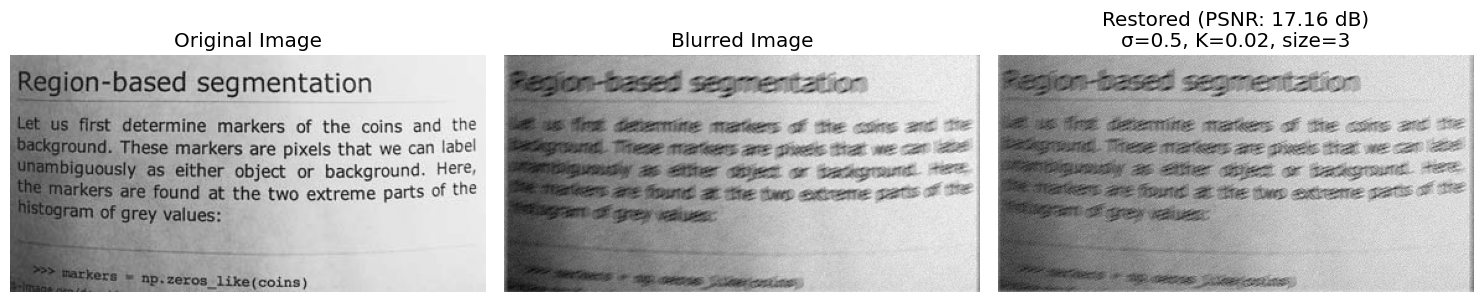

In [32]:
# Grid search for optimal parameters
best_psnr = 0
best_sigma = 0
best_K = 0
best_kernel_size = 0
best_restored = None

# Parameter ranges to search
sigma_range = np.arange(0.5, 10.0, 0.5)
K_range = [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1]
kernel_sizes = [3, 5, 7, 9, 11, 13, 15]

for kernel_size in kernel_sizes:
    for sigma in sigma_range:
        for K in K_range:
            # Create Gaussian kernel estimate
            gaussian_kernel = get_gaussian_kernel(kernel_size, sigma)
            
            # Restore using Wiener filter
            restored = wiener_deconvolution_2d(mystery_observed, gaussian_kernel, K)
            
            # Calculate PSNR
            psnr = calculate_psnr(gt_img, restored)
            
            if psnr > best_psnr:
                best_psnr = psnr
                best_sigma = sigma
                best_K = K
                best_kernel_size = kernel_size
                best_restored = restored

print(f"Optimal Parameters Found:")
print(f"  Kernel Size: {best_kernel_size}")
print(f"  Sigma: {best_sigma}")
print(f"  K (noise parameter): {best_K}")
print(f"  Best PSNR: {best_psnr:.2f} dB")

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(gt_img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(mystery_observed, cmap='gray')
axes[1].set_title('Blurred Image')
axes[1].axis('off')

axes[2].imshow(best_restored, cmap='gray')
axes[2].set_title(f'Restored (PSNR: {best_psnr:.2f} dB)\nσ={best_sigma}, K={best_K}, size={best_kernel_size}')
axes[2].axis('off')

plt.tight_layout()
plt.show()